Final panel shape: (6840, 40)

Class distribution in y:
y
0    4655
1    2185
Name: count, dtype: int64

X shape: (6840, 20)
Any NaN in X ? -> False

Train size: 4788
Test size : 2052

===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1396
           1       0.67      0.31      0.43       656

    accuracy                           0.73      2052
   macro avg       0.70      0.62      0.63      2052
weighted avg       0.72      0.73      0.70      2052


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1396
           1       0.74      0.62      0.68       656

    accuracy                           0.81      2052
   macro avg       0.79      0.76      0.77      2052
weighted avg       0.81      0.81      0.81      2052


===== XGBoost =====
              precision    recall  f1-score   support

           0       0.84   

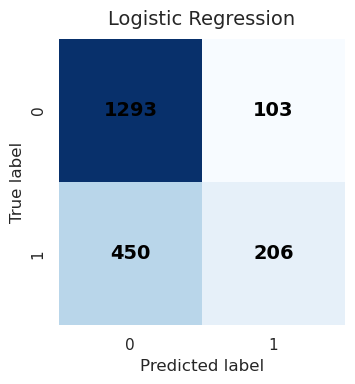

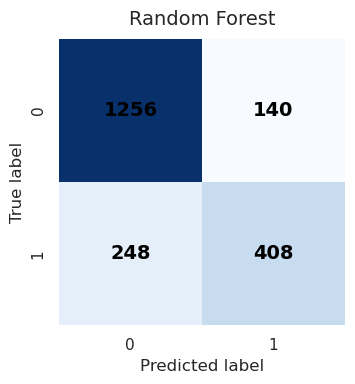

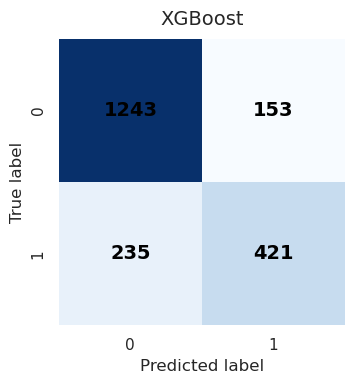

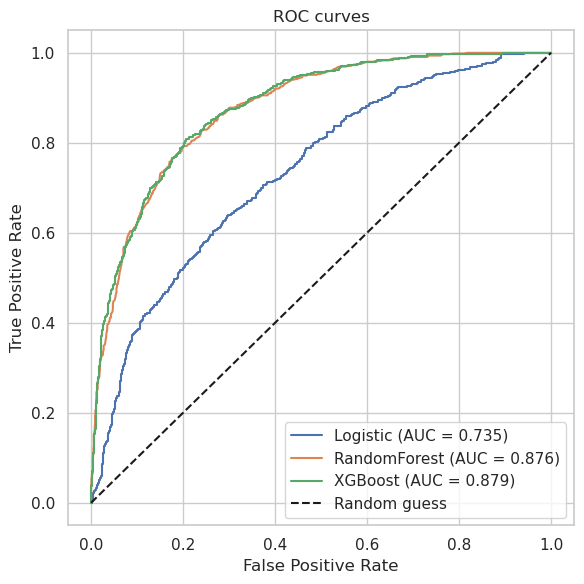


===== Final Model Comparison =====
              Accuracy  Precision (1)  Recall (1)  F1-score (1)    AUC
Logistic         0.731          0.667       0.314         0.427  0.735
RandomForest     0.811          0.745       0.622         0.678  0.876
XGBoost          0.811          0.733       0.642         0.685  0.879


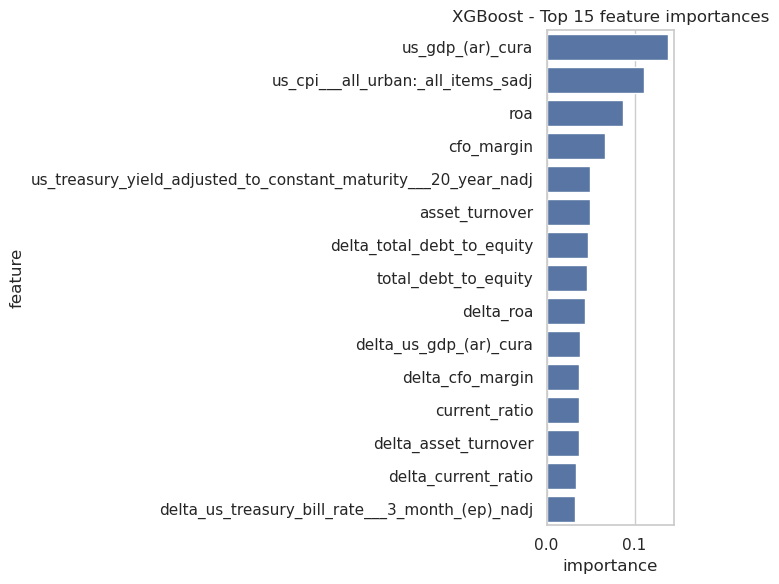

,feature,importance
10,us_gdp_(ar)_cura,0.138001
11,us_cpi___all_urban:_all_items_sadj,0.110905
0,roa,0.086720
3,cfo_margin,0.065991
13,us_treasury_yield_adjusted_to_constant_maturit...,0.049782
4,asset_turnover,0.048930
6,delta_total_debt_to_equity,0.046999
1,total_debt_to_equity,0.045619
5,delta_roa,0.043112
15,delta_us_gdp_(ar)_cura,0.038403



===== Logistic Regression – detailed report =====


,precision,recall,f1-score,support
0,0.742,0.926,0.824,1396.000
1,0.667,0.314,0.427,656.000
accuracy,0.731,0.731,0.731,0.731
macro avg,0.704,0.620,0.625,2052.000
weighted avg,0.718,0.731,0.697,2052.000



===== Random Forest – detailed report =====


,precision,recall,f1-score,support
0,0.835,0.900,0.866,1396.000
1,0.745,0.622,0.678,656.000
accuracy,0.811,0.811,0.811,0.811
macro avg,0.790,0.761,0.772,2052.000
weighted avg,0.806,0.811,0.806,2052.000



===== XGBoost – detailed report =====


,precision,recall,f1-score,support
0,0.841,0.890,0.865,1396.000
1,0.733,0.642,0.685,656.000
accuracy,0.811,0.811,0.811,0.811
macro avg,0.787,0.766,0.775,2052.000
weighted avg,0.807,0.811,0.807,2052.000


In [7]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import xgboost as xgb

sns.set(style="whitegrid")

# =========================
# 1. Load final panel
# =========================

base = "/files/financial-kpis-analysis-and-distress-prediction/"
data_path = os.path.join(base, "data/final/panel_balanced_with_deltas.csv")

df = pd.read_csv(data_path)
print("Final panel shape:", df.shape)

# =========================
# 2. Build X and y
# =========================

y = df["y"].astype(int)
print("\nClass distribution in y:")
print(y.value_counts())

kpi_cols = [
    "roa",
    "total_debt_to_equity",
    "current_ratio",
    "cfo_margin",
    "asset_turnover",
]

delta_kpi_cols = [
    "delta_roa",
    "delta_total_debt_to_equity",
    "delta_current_ratio",
    "delta_cfo_margin",
    "delta_asset_turnover",
]

macro_cols = [
    "us_gdp_(ar)_cura",
    "us_cpi___all_urban:_all_items_sadj",
    "us_treasury_bill_rate___3_month_(ep)_nadj",
    "us_treasury_yield_adjusted_to_constant_maturity___20_year_nadj",
    "us_unemployment_rate_sadj",
]

delta_macro_cols = [
    "delta_us_gdp_(ar)_cura",
    "delta_us_cpi___all_urban:_all_items_sadj",
    "delta_us_treasury_bill_rate___3_month_(ep)_nadj",
    "delta_us_treasury_yield_adjusted_to_constant_maturity___20_year_nadj",
    "delta_us_unemployment_rate_sadj",
]

feature_cols = kpi_cols + delta_kpi_cols + macro_cols + delta_macro_cols
X = df[feature_cols].copy()

print("\nX shape:", X.shape)
print("Any NaN in X ? ->", X.isna().any().any())

feature_names = X.columns.tolist()

# =========================
# 3. Train / test split + imputation
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("\nTrain size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# =========================
# 4. Train models
# =========================

results = {}
probas_test = {}

# ----- Logistic Regression -----
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_imp)
X_test_lr = scaler.transform(X_test_imp)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_lr, y_train)

y_pred_lr = lr.predict(X_test_lr)
y_proba_lr = lr.predict_proba(X_test_lr)[:, 1]

results["Logistic"] = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "auc": roc_auc_score(y_test, y_proba_lr),
}
probas_test["Logistic"] = y_proba_lr

print("\n===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr))

# ----- Random Forest -----
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train_imp, y_train)

y_pred_rf = rf.predict(X_test_imp)
y_proba_rf = rf.predict_proba(X_test_imp)[:, 1]

results["RandomForest"] = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "auc": roc_auc_score(y_test, y_proba_rf),
}
probas_test["RandomForest"] = y_proba_rf

print("\n===== Random Forest =====")
print(classification_report(y_test, y_pred_rf))

# ----- XGBoost -----
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train_imp, y_train)

y_pred_xgb = xgb_model.predict(X_test_imp)
y_proba_xgb = xgb_model.predict_proba(X_test_imp)[:, 1]

results["XGBoost"] = {
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "auc": roc_auc_score(y_test, y_proba_xgb),
}
probas_test["XGBoost"] = y_proba_xgb

print("\n===== XGBoost =====")
print(classification_report(y_test, y_pred_xgb))

# =========================
# 5. Confusion matrices (clean)
# =========================

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        square=True,
        annot_kws={"size": 14, "weight": "bold", "color": "black"},
    )
    plt.title(title, fontsize=14, pad=10)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost")

# =========================
# 6. ROC curves
# =========================

plt.figure(figsize=(6, 6))

for name, proba in probas_test.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = results[name]["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# =========================
# 7. Final metrics table
# =========================

def compute_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (1)": precision_score(y_true, y_pred, pos_label=1),
        "Recall (1)": recall_score(y_true, y_pred, pos_label=1),
        "F1-score (1)": f1_score(y_true, y_pred, pos_label=1),
        "AUC": roc_auc_score(y_true, y_proba),
    }

summary_clean = pd.DataFrame({
    "Logistic": compute_metrics(y_test, y_pred_lr, y_proba_lr),
    "RandomForest": compute_metrics(y_test, y_pred_rf, y_proba_rf),
    "XGBoost": compute_metrics(y_test, y_pred_xgb, y_proba_xgb),
}).T

print("\n===== Final Model Comparison =====")
print(summary_clean.round(3))

# =========================
# 8. XGBoost feature importance (top 15)
# =========================

importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(7, 6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature")
plt.title("XGBoost - Top 15 feature importances")
plt.tight_layout()
plt.show()

display(feat_imp.head(15))

# =========================
# 9. Pretty tables per model (DataFrame version of classification_report)
# =========================

def report_to_df(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(rep).T.round(3)

print("\n===== Logistic Regression – detailed report =====")
df_log = report_to_df(y_test, y_pred_lr)
display(df_log)

print("\n===== Random Forest – detailed report =====")
df_rf = report_to_df(y_test, y_pred_rf)
display(df_rf)

print("\n===== XGBoost – detailed report =====")
df_xgb = report_to_df(y_test, y_pred_xgb)
display(df_xgb)
